In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap


In [2]:
# def animate_pendulum(t, sol):
#     # Visualization
#     fig, ax = plt.subplots(figsize=(15, 8))
#     ax.set_xlim(-10, 10)
#     ax.set_ylim(-1, 5)

#     # Initial drawing elements
#     left_wheel = ax.scatter([-0.5], [0.25], s=1000, c="k")
#     right_wheel = ax.scatter([0.5], [0.25], s=1000, c="k")
#     ax.plot([-10, 10], [0, 0], "k-")  # Ground
#     cart_body, = ax.plot([-0.8, 0.8], [0.65, 0.65], "b-", linewidth=30)
#     pendulum_arm, = ax.plot([0, 0], [0.7, 0.7 + arm_length], "k-", lw=2)
#     pendulum_bob, = ax.plot([0], [0.7 + arm_length], 'ro', ms=15)

#     def update(frame):
#         x = sol[frame][0]
#         theta = sol[frame][2]
#         left_wheel.set_offsets([-.5 + x, .25])
#         right_wheel.set_offsets([.5 + x, .25])
#         cart_body.set_data([-.8 + x, .8 + x], [.65, 0.65])
#         pendulum_arm.set_data([x, x + arm_length * np.sin(theta) ], [0.7, 0.7 - arm_length * np.cos(theta)])
#         pendulum_bob.set_data([x + arm_length * np.sin(theta)], [0.7 - arm_length * np.cos(theta)])
#         return left_wheel, right_wheel, cart_body , pendulum_arm, pendulum_bob


#     animation = FuncAnimation(fig, update, frames=len(t), blit=True, interval=25, repeat=False)
#     plt.close(fig)
#     return HTML(animation.to_jshtml())


# def run_simulation(x0, seconds=5, frames_per_second = 50, pend_mass=pend_mass, cart_mass=cart_mass, arm_length=arm_length, g=g, d=d, b=b):
#     A = get_A_matrix(pend_mass, cart_mass, arm_length, g, d, b)
#     B = get_B_matrix(cart_mass, arm_length, b)
#     Q = np.diag([1, 1, 1, 1])
#     R = np.array([[0.0001]])

#     K, S, E = control.lqr(A, B, Q, R)

    
#     sec_per_frame = 1 / frames_per_second 

#     t = np.arange(0, seconds, sec_per_frame)
#     sol = odeint(dynamics, x0, t, args=(K, pend_mass, cart_mass, arm_length, g, d, b))
                                                    
#     plot_graphs(t, sol)
#     return animate_pendulum(t, sol)






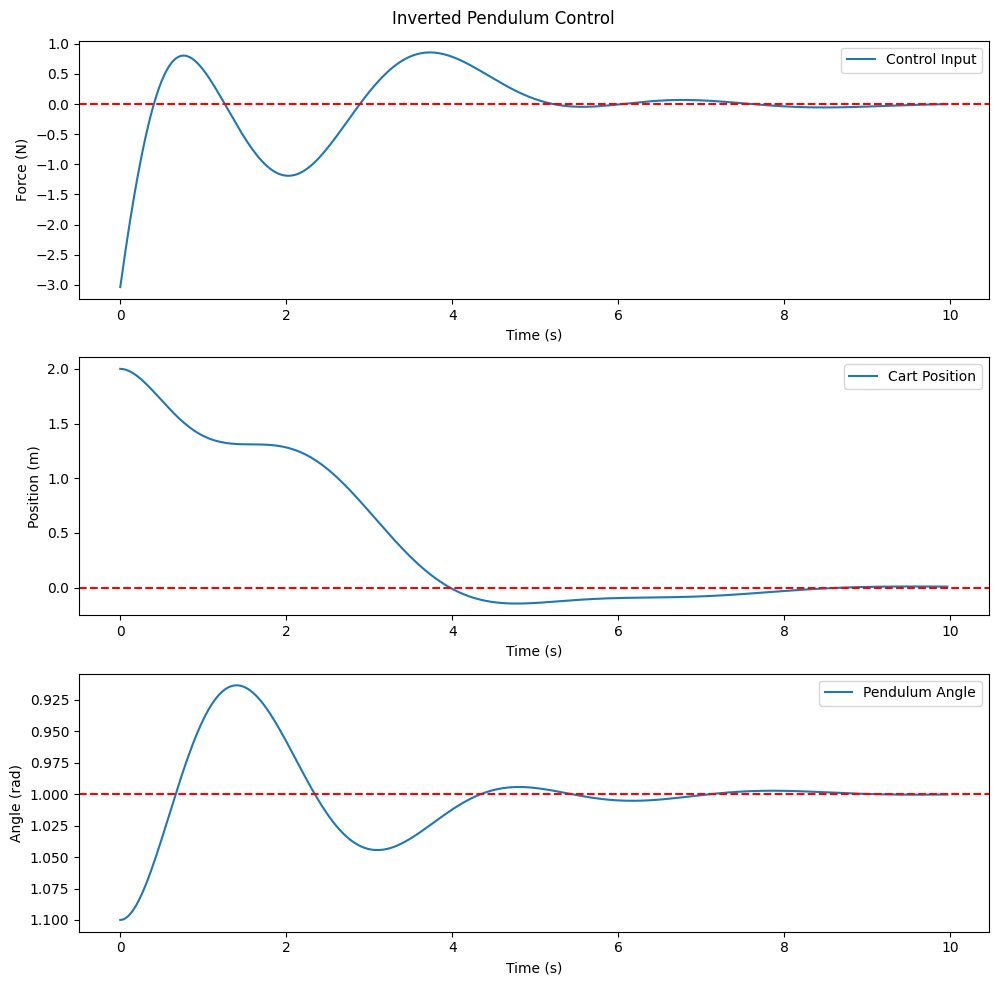

In [3]:
m = 0.3
M = 1.0
L = 3
g = 9.8
delta = 0.1

def dynamics(y, m, M, L, g, delta, u):
    """
    Compute the state derivatives.
    :param y: state vector
    :param m: pendulum mass
    :param M: cart mass
    :param L: pendulum length
    :param g: gravitational acceleration
    :param delta: friction damping
    :param u: control input
    :return: dy: state derivative
    """
    theta = y[2]
    theta_dot = y[3]
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    D = m * (L ** 2) * (M + m * (1 - cos_theta ** 2))    
    dy = np.array([
        y[1],
        (1 / D) * (
            -(m ** 2) * (L ** 2) * g * cos_theta * sin_theta 
            + m * (L ** 2) * (m * L * (theta_dot ** 2) * sin_theta - delta * y[1])
        ) + m * (L ** 2) * (1 / D) * u,
        y[3],
        (1 / D) * (
            (m + M) * m * g * L * sin_theta 
            - m * L * cos_theta * (m * L * (theta_dot ** 2) * sin_theta 
            - delta * y[1])
        ) - m * L * cos_theta * (1 / D) * u
    ])
    return dy

def get_a_matrix(m, M, L, g, delta):
    """
    :return A: state matrix
    """
    A = np.array([
        [0, 1, 0, 0],
        [0, -delta / M, m * g / M, 0],
        [0, 0, 0, 1],
        [0, -delta / (M * L), - (M + m) * g / (M * L), 0]
    ])
    return A

def get_b_matrix(m, M, L, g, delta):
    """
    :return B: input matrix
    """
    B = np.array([
        [0],
        [1 / M],
        [0],
        [1 / (M * L)]
    ])
    return B


def dynamics_with_control(y, t, y_goal, m, M, L, g, delta, K):
    """
    Compute the state derivative with control input.
    :param K: state feedback gain matrix
    :return dy: state derivative
    """
    u = np.dot(-K, y - y_goal )[0]
    return dynamics(y, m, M, L, g, delta, u)


def degrees_to_radians(y):
    return (y % (2 * np.pi)) / np.pi 


def compute_control_input(y, y_goal, K):
    """
    Compute the control input vector u based on the state vector y.
    :param y: state vector
    :param y_goal: goal state vector
    :param K: state feedback gain matrix
    :return: control input vector u
    """
    return np.array([np.dot(-K, y_i - y_goal) for y_i in y])


def plot_results(t, u, y):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    
    axs[0].plot(t, u, label='Control Input')
    axs[0].set_ylabel('Force (N)')
    axs[0].set_xlabel('Time (s)')
    axs[0].legend()
    axs[0].axhline(y=0, color='r', linestyle='--')

    axs[1].plot(t, y[:, 0], label='Cart Position')
    axs[1].set_ylabel('Position (m)')
    axs[1].set_xlabel('Time (s)')
    axs[1].legend()
    axs[1].axhline(y=0, color='r', linestyle='--')

    axs[2].plot(t, degrees_to_radians(y[:, 2]), label='Pendulum Angle')
    axs[2].set_ylabel('Angle (rad)')
    axs[2].set_xlabel('Time (s)')
    axs[2].legend()
    axs[2].axhline(y=1, color='r', linestyle='--')
    axs[2].invert_yaxis()

    fig.suptitle('Inverted Pendulum Control')
    plt.tight_layout()
    plt.show()


tf = 10
dt = float(1 / 30)
t = np.arange(0, tf, dt)


A = get_a_matrix(m, M, L, g, delta)
B = get_b_matrix(m, M, L, g, delta)
Q = np.diag([1,1,1,1])
R = np.array([[1]])
y_goal = np.array([0, 0, np.pi * 1, 0])


K, S, E = control.lqr(A, B, Q, R)

y0 = np.array([2, 0, np.pi * (1 + 0.1), 0])
y = odeint(dynamics_with_control, y0, t, args=(y_goal, m, M, L, g, delta, K))
u = compute_control_input(y, y_goal, K)




plot_results(t, u, y)

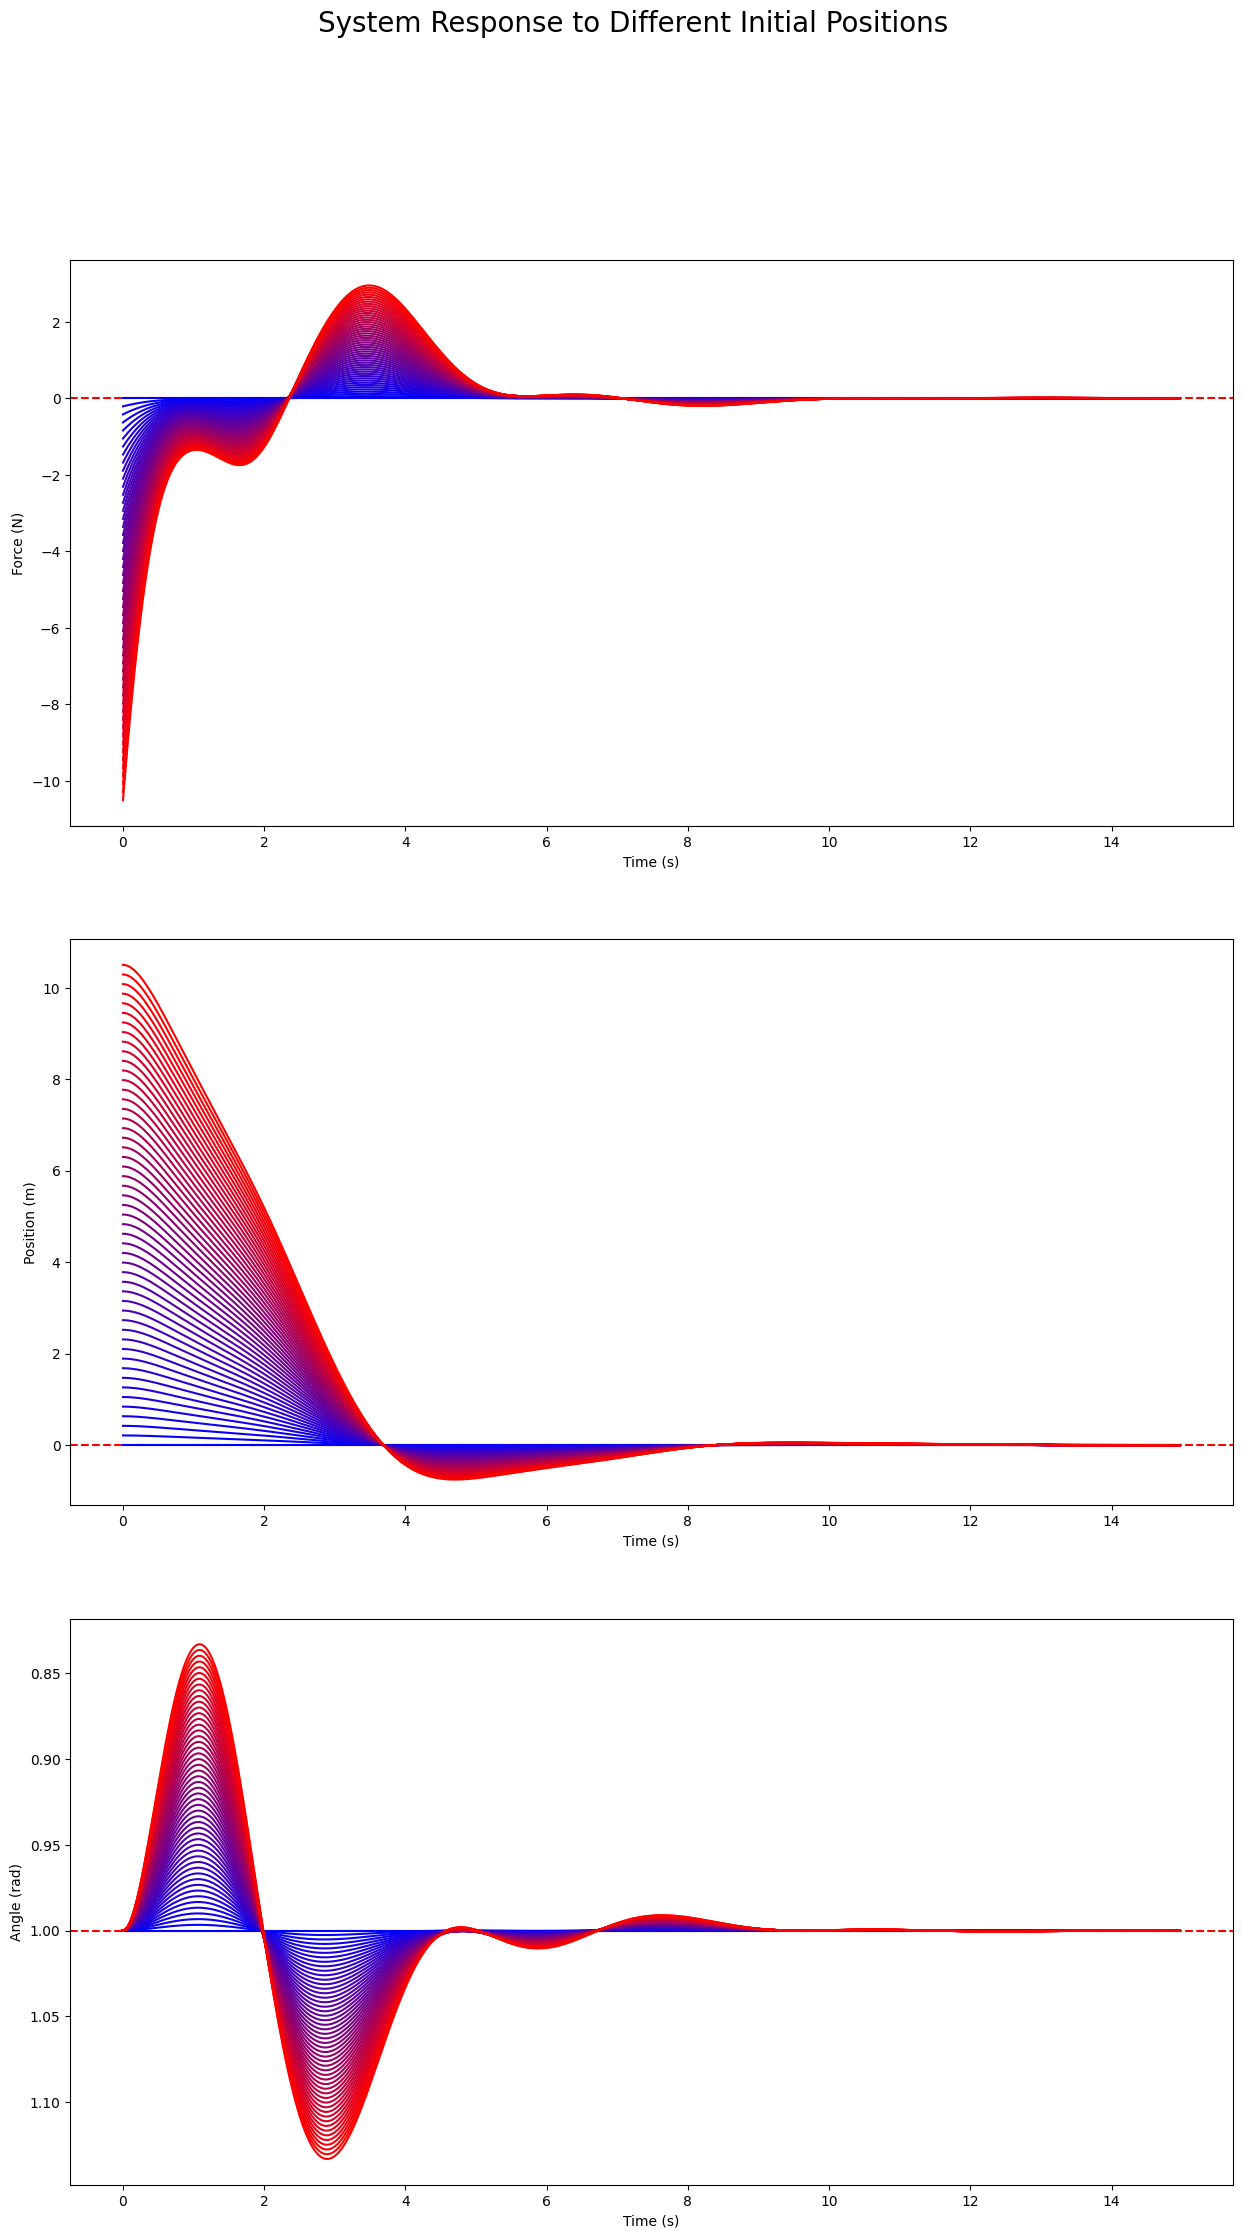

In [4]:
color1 = "blue"
color2 = "red"
N = 50
cmap = LinearSegmentedColormap.from_list("custom_cmap", [color1, color2], N=N)
colors = cmap(range(0, N+1))

tf = 15
dt = float(1 / 30)
t = np.arange(0, tf, dt)

A = get_a_matrix(m, M, L, g, delta)
B = get_b_matrix(m, M, L, g, delta)
Q = np.diag([1,1,1,1])
R = np.array([[1]])
y_goal = np.array([0, 0, np.pi * 1, 0])

K, S, E = control.lqr(A, B, Q, R)

fig, axs = plt.subplots(3, 1, figsize=(15, 25))
axs[0].set_ylabel('Force (N)')
axs[0].set_xlabel('Time (s)')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[1].set_ylabel('Position (m)')
axs[1].set_xlabel('Time (s)')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[2].set_ylabel('Angle (rad)')
axs[2].set_xlabel('Time (s)')
axs[2].axhline(y=1, color='r', linestyle='--')
axs[2].invert_yaxis()



for i, x0 in enumerate(np.linspace(0,10.5,N+1)):
    y0 = np.array([x0, 0, np.pi, 0])
    y = odeint(dynamics_with_control, y0, t, args=(y_goal, m, M, L, g, delta, K))
    u = compute_control_input(y, y_goal, K)
    axs[0].plot(t, u, color=colors[i])
    axs[1].plot(t, y[:, 0], color=colors[i])
    axs[2].plot(t, degrees_to_radians(y[:, 2]), color=colors[i])


fig.suptitle('System Response to Different Initial Positions', fontsize=20)
plt.show()




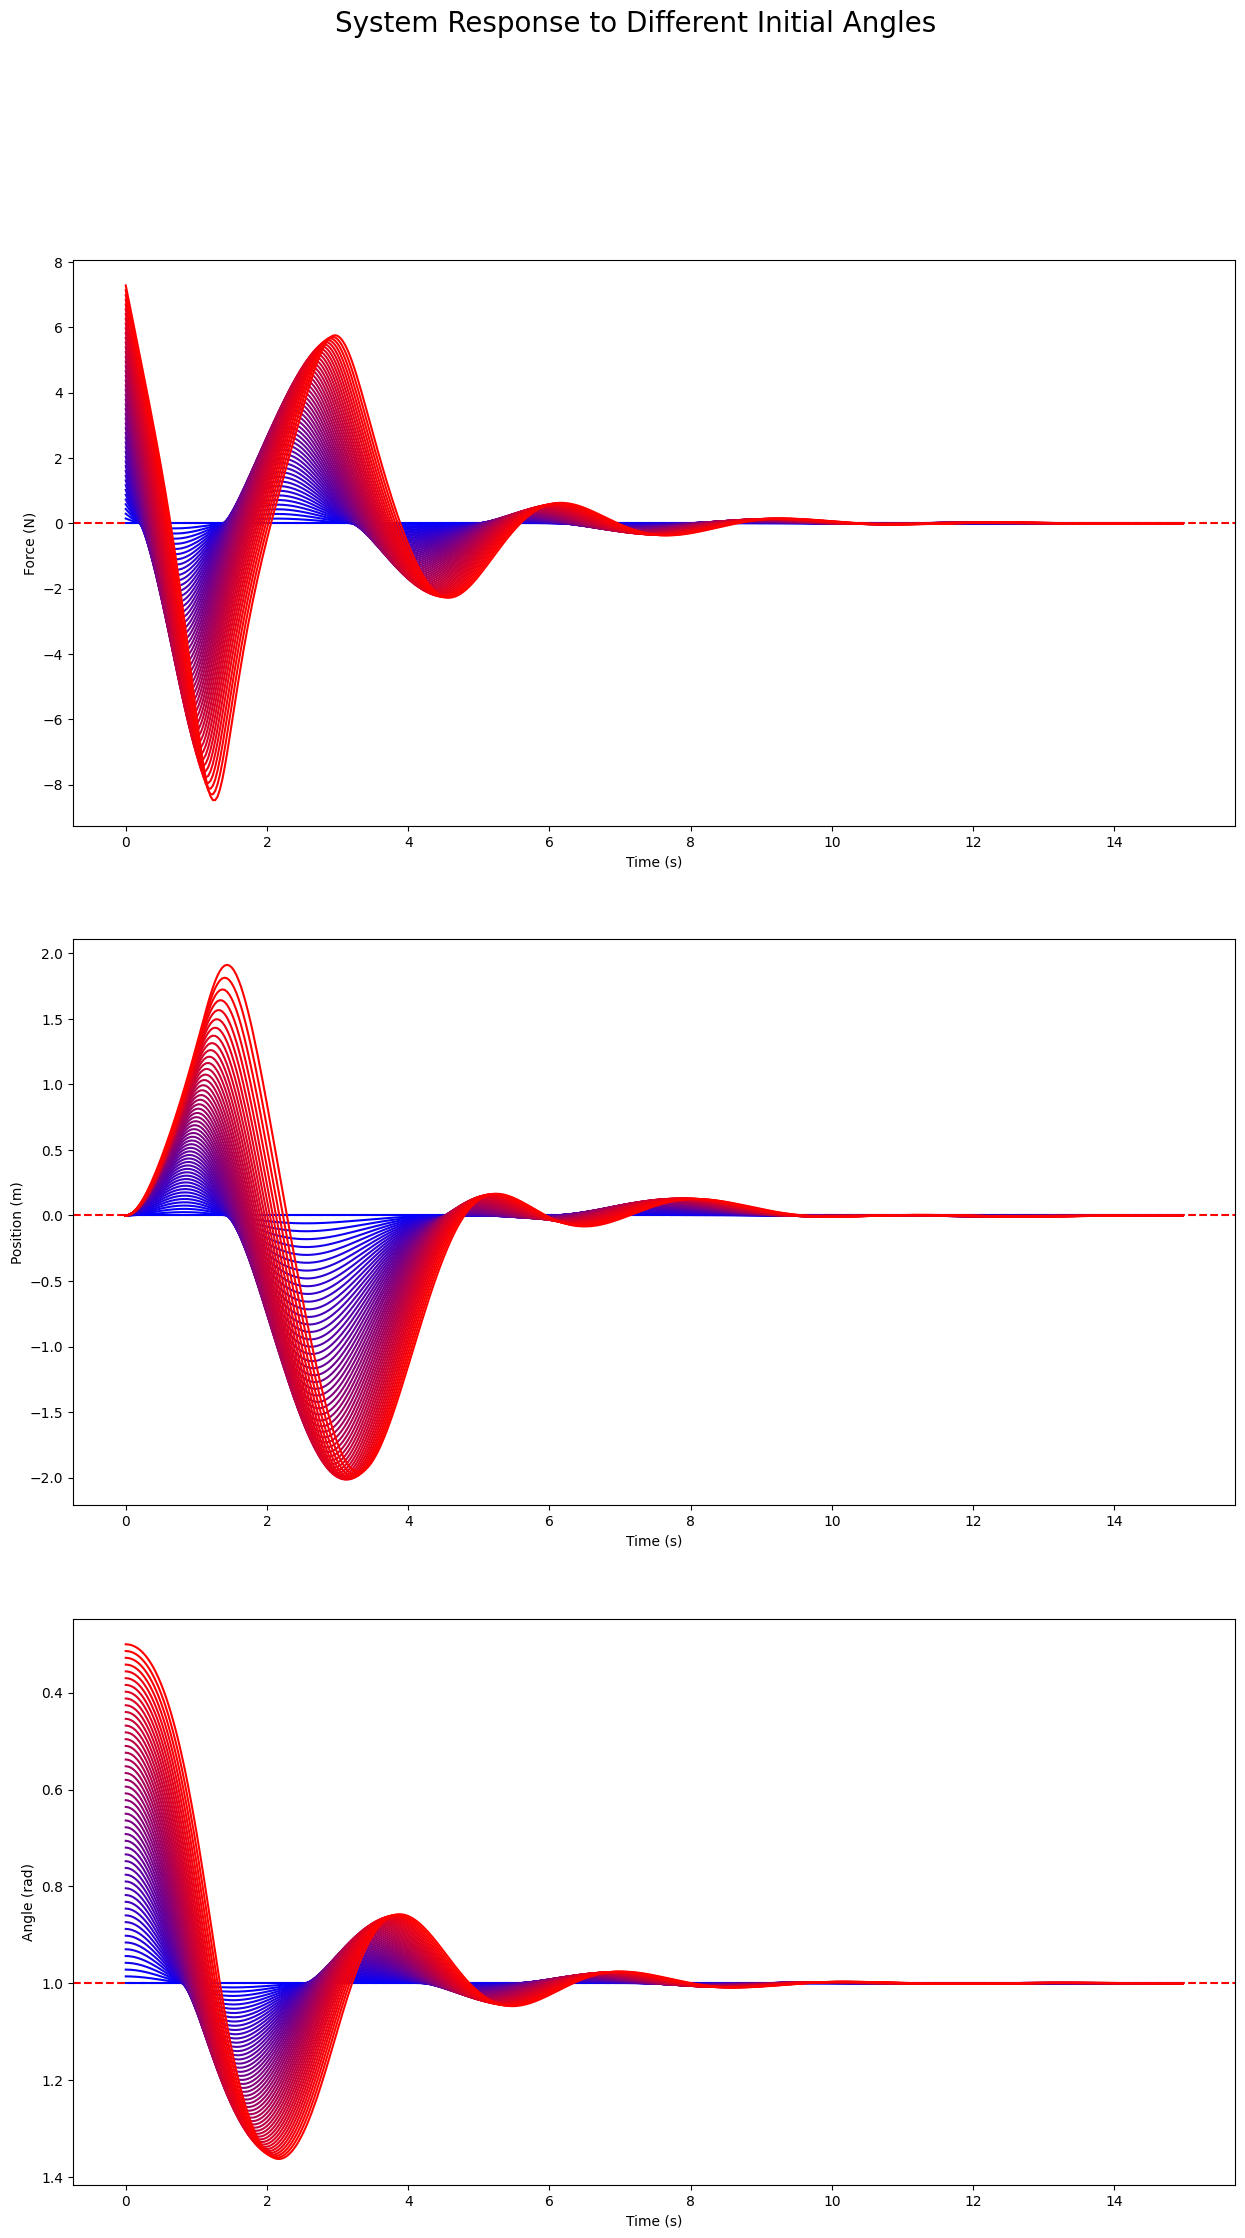

In [5]:
A = get_a_matrix(m, M, L, g, delta)
B = get_b_matrix(m, M, L, g, delta)
Q = np.diag([1,1,1,1])
R = np.array([[1]])
y_goal = np.array([0, 0, np.pi * 1, 0])

K, S, E = control.lqr(A, B, Q, R)

fig, axs = plt.subplots(3, 1, figsize=(15, 25))
axs[0].set_ylabel('Force (N)')
axs[0].set_xlabel('Time (s)')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[1].set_ylabel('Position (m)')
axs[1].set_xlabel('Time (s)')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[2].set_ylabel('Angle (rad)')
axs[2].set_xlabel('Time (s)')
axs[2].axhline(y=1, color='r', linestyle='--')
axs[2].invert_yaxis()


for i, radian in enumerate(np.linspace(0, 0.7, N+1)):
    y0 = np.array([0, 0, (1 - radian) * np.pi, 0])
    y = odeint(dynamics_with_control, y0, t, args=(y_goal, m, M, L, g, delta, K))
    u = compute_control_input(y, y_goal, K)
    axs[0].plot(t, u, color=colors[i])
    axs[1].plot(t, y[:, 0], color=colors[i])
    axs[2].plot(t, degrees_to_radians(y[:, 2]), color=colors[i])


fig.suptitle('System Response to Different Initial Angles', fontsize=20)
plt.show()


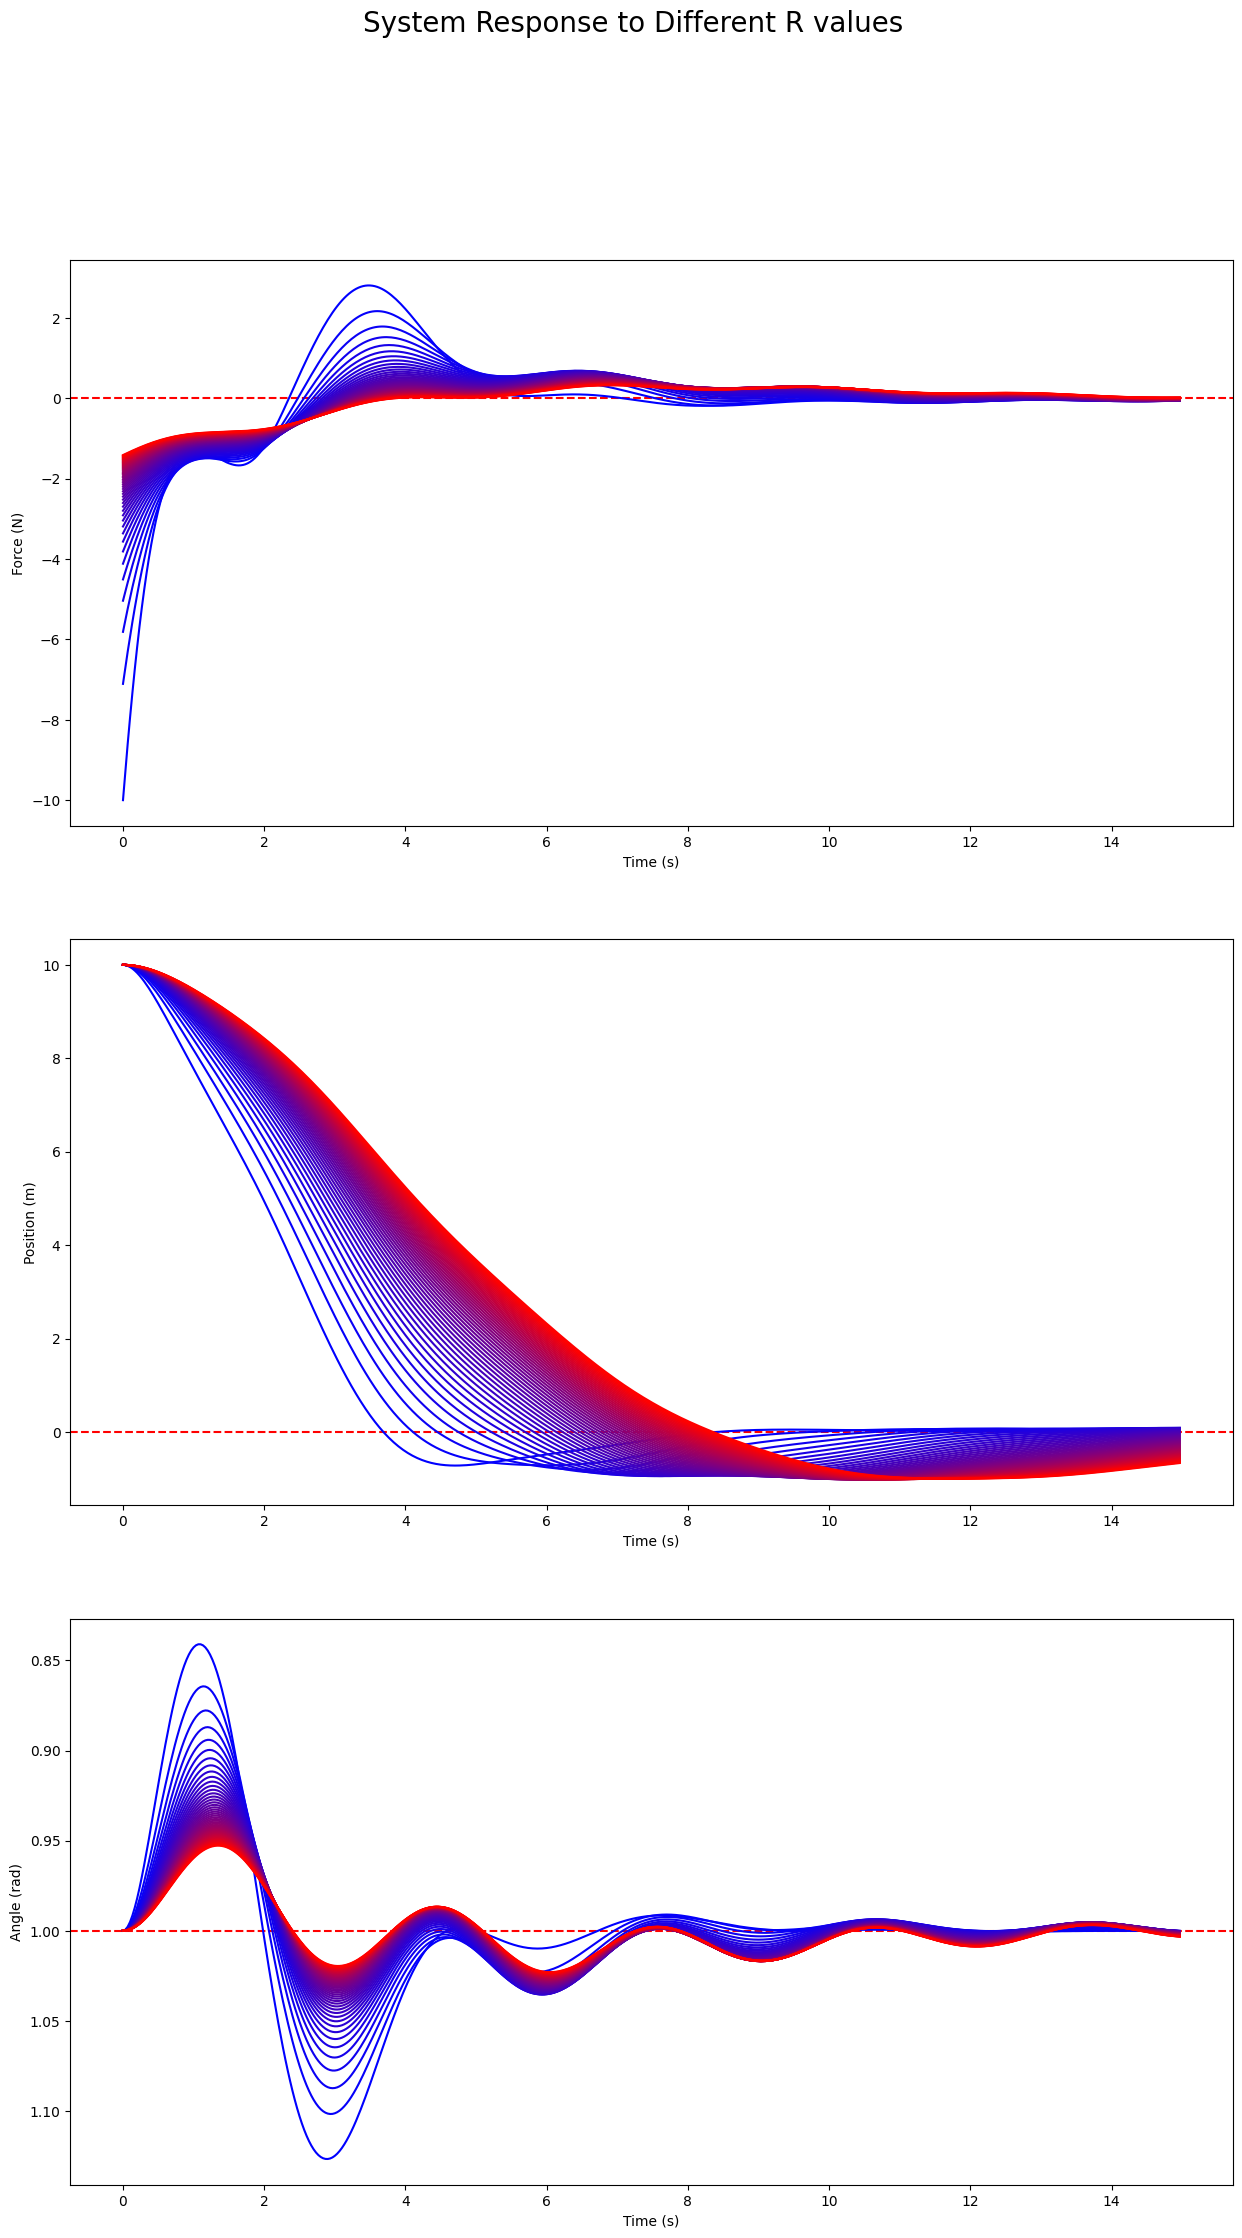

In [6]:

A = get_a_matrix(m, M, L, g, delta)
B = get_b_matrix(m, M, L, g, delta)
Q = np.diag([1,1,1,1])
y_goal = np.array([0, 0, np.pi * 1, 0])
x0 = 10

fig, axs = plt.subplots(3, 1, figsize=(15, 25))
axs[0].set_ylabel('Force (N)')
axs[0].set_xlabel('Time (s)')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[1].set_ylabel('Position (m)')
axs[1].set_xlabel('Time (s)')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[2].set_ylabel('Angle (rad)')
axs[2].set_xlabel('Time (s)')
axs[2].axhline(y=1, color='r', linestyle='--')
axs[2].invert_yaxis()


for i, r in enumerate(np.linspace(1, 50, N+1)):
    R = np.array([[r]])
    K, S, E = control.lqr(A, B, Q, R)

    y0 = np.array([x0, 0, np.pi, 0])
    y = odeint(dynamics_with_control, y0, t, args=(y_goal, m, M, L, g, delta, K))
    u = compute_control_input(y, y_goal, K)
    axs[0].plot(t, u, color=colors[i])
    axs[1].plot(t, y[:, 0], color=colors[i])
    axs[2].plot(t, degrees_to_radians(y[:, 2]), color=colors[i])


fig.suptitle('System Response to Different R values', fontsize=20)
plt.show()


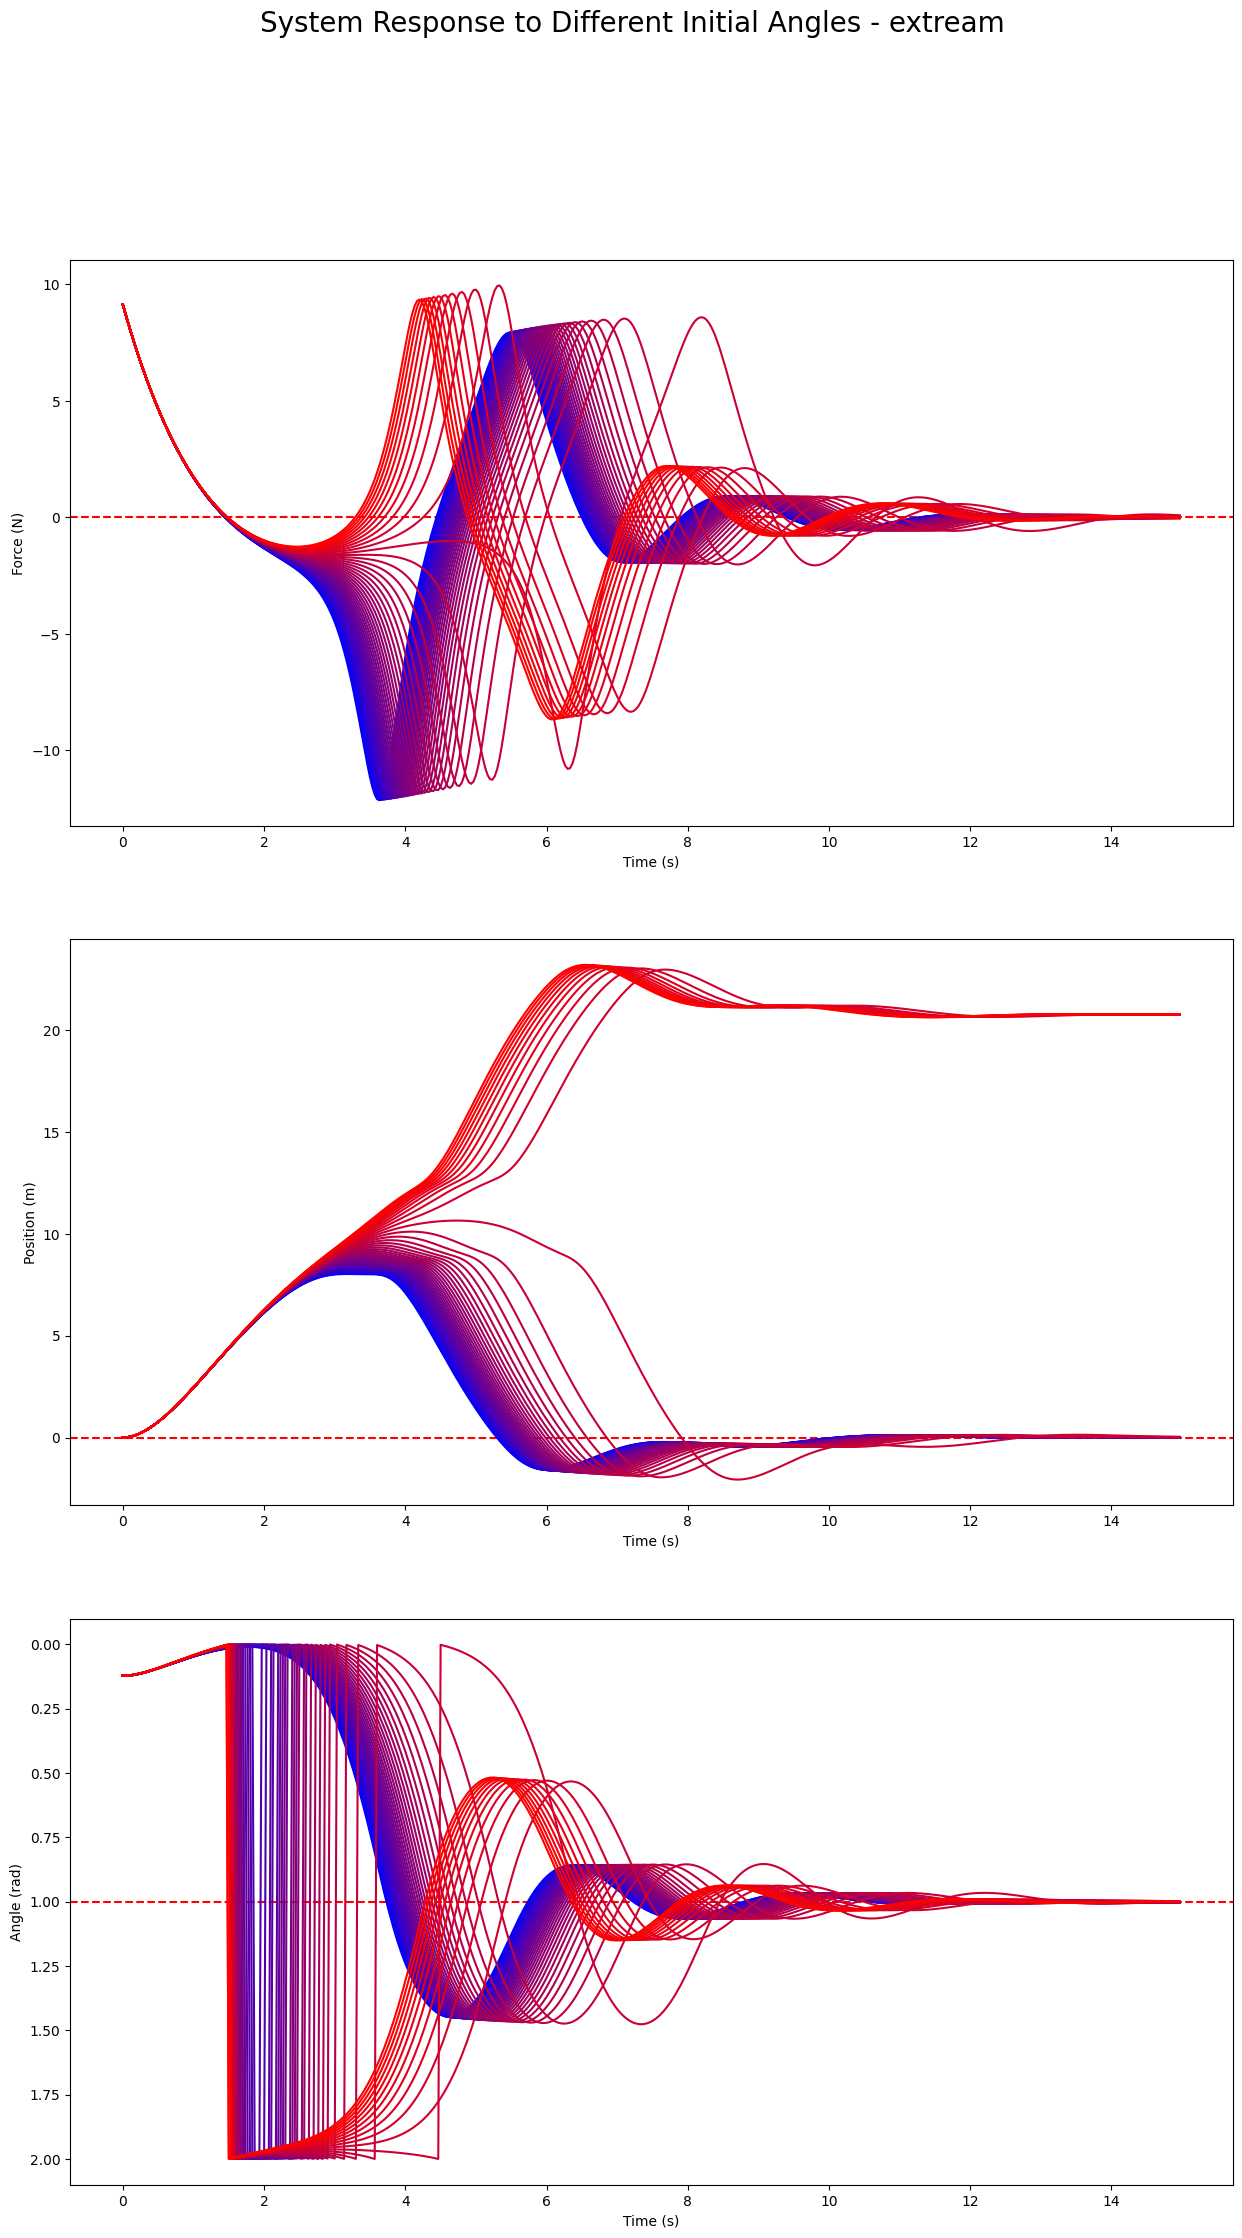

In [24]:
A = get_a_matrix(m, M, L, g, delta)
B = get_b_matrix(m, M, L, g, delta)
Q = np.diag([1,1,1,1])
R = np.array([[1]])
y_goal = np.array([0, 0, np.pi * 1, 0])

K, S, E = control.lqr(A, B, Q, R)

fig, axs = plt.subplots(3, 1, figsize=(15, 25))
axs[0].set_ylabel('Force (N)')
axs[0].set_xlabel('Time (s)')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[1].set_ylabel('Position (m)')
axs[1].set_xlabel('Time (s)')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[2].set_ylabel('Angle (rad)')
axs[2].set_xlabel('Time (s)')
axs[2].axhline(y=1, color='r', linestyle='--')
axs[2].invert_yaxis()


for i, radian in enumerate(np.linspace(0.877, 0.878, N+1)):
    y0 = np.array([0, 0, (1 - radian) * np.pi, 0])
    y = odeint(dynamics_with_control, y0, t, args=(y_goal, m, M, L, g, delta, K))
    u = compute_control_input(y, y_goal, K)
    axs[0].plot(t, u, color=colors[i])
    axs[1].plot(t, y[:, 0], color=colors[i])
    axs[2].plot(t, degrees_to_radians(y[:, 2]), color=colors[i])


fig.suptitle('System Response to Different Initial Angles - extream', fontsize=20)
plt.show()
